In [1]:
import logging

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from custom_losses import *
from custom_metrics import *
from preprocessing import *
from models import build_unet, build_w_net
import os
import cv2
from PIL import Image


In [2]:
logging.getLogger().setLevel(logging.WARNING)

In [3]:
# Define paths to your dataset
image_folder = 'DRIVE/training/images'
label_folder = 'DRIVE/training/manual'
mask_folder = 'DRIVE/training/mask'
test_image_folder = 'DRIVE/test/images'
test_label_folder = 'DRIVE/test/manual'
test_mask_folder = 'DRIVE/training/mask'
# Get list of all files in the image and label directories
image_files = sorted(os.listdir(image_folder))
label_files = sorted(os.listdir(label_folder))
mask_files = sorted(os.listdir(mask_folder))
test_image_files = sorted(os.listdir(test_image_folder))
test_label_files = sorted(os.listdir(test_label_folder))
test_mask_files = sorted(os.listdir(test_mask_folder))

In [4]:
# Function to preprocess images and labels
def preprocess(image_path, label_path, mask_path):
    # Convert the TensorFlow Tensor object to a string
    image_path = image_path.decode('utf-8')
    label_path = label_path.decode('utf-8')
    mask_path = mask_path.decode('utf-8')
    # Load image and label
    image = cv2.imread(image_path)[..., 1]
    try:
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if label is None or mask is None:
            raise FileNotFoundError
    except FileNotFoundError:
        lb = Image.open(label_path)
        lb.seek(lb.tell())
        label = np.array(lb)
        mask = Image.open(mask_path)
        mask.seek(mask.tell())
        mask = np.array(mask).astype(np.uint8)
    # Resize images and labels
    input = ResizePreprocessor(512, 512)
    x = CLAHE()(input)
    x = MedianBlurPreprocessor()(x)
    x = GammaCorrectionPreprocessor()(x)
    x = MultiScaleMorphologicalPreprocessor(
        operation='open',  # Options: 'dilate', 'erode', 'open', 'close'
        kernel_sizes=[3, 5, 7],
        kernel_shape=cv2.MORPH_RECT,
        iterations=1
    )(x)
    NormalizePreprocessor()(x)
    for_labels = ResizePreprocessor(512, 512)
    NormalizePreprocessor()(for_labels)
    image = input.process(image)[:, :, np.newaxis].astype('float32')
    label = for_labels.process(label)[:, :, np.newaxis].astype('float32')
    mask = for_labels.process(mask)[:, :, np.newaxis].astype('float32')
    image *= mask
    label *= mask
    return image, label



In [5]:
# Function to load the dataset into tf.data.Dataset
def load_dataset(image_folder,image_files, label_folder, label_files, mask_folder, mask_files):
    # Create file paths
    image_paths = [os.path.join(image_folder, f) for f in image_files]
    label_paths = [os.path.join(label_folder, f) for f in label_files]
    mask_paths = [os.path.join(mask_folder, f) for f in mask_files]
    # Create a TensorFlow dataset from the file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths, mask_paths))
    
    # Map the preprocessing function to each element in the dataset
    dataset = dataset.map(lambda img_path, lbl_path, m_path: tf.numpy_function(
                          func=preprocess, inp=[img_path, lbl_path, m_path], 
                          Tout=[tf.float32, tf.float32]))
    
    # Shuffle and batch the dataset
    dataset = dataset.shuffle(buffer_size=len(image_paths))
    dataset = dataset.batch(4)  # Set batch size to 32, modify as needed
    
    return dataset



In [6]:
# Load the dataset
dataset = load_dataset(image_folder, image_files, label_folder, label_files, mask_folder, mask_files)
test_dataset= load_dataset(test_image_folder, test_image_files, test_label_folder, test_label_files, test_mask_folder, test_mask_files)

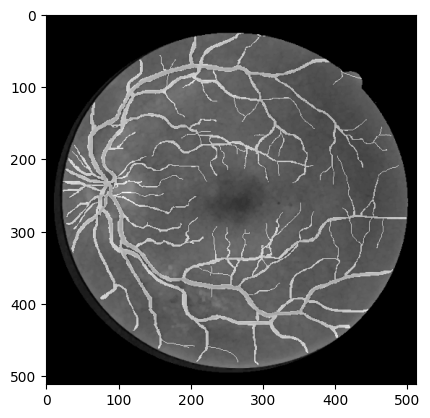

In [7]:
for image, label in test_dataset:
    
    plt.imshow(image[0]*.6 + label[0]*.4, cmap='gray')

In [13]:
# Define the total number of epochs
total_epochs = 1000

# Set the initial learning rate, decay steps, and minimum learning rate
initial_learning_rate = 1E-2
decay_steps = 50
alpha = 1E-8
class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Get the learning rate from the optimizer
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            current_lr = lr(tf.cast(self.model.optimizer.iterations, tf.float32))
        else:
            current_lr = lr
        print(f"Epoch {epoch + 1}: Learning rate is {current_lr.numpy()}")

# Create a cosine decay schedule with restarts and a minimum learning rate
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=initial_learning_rate,
    first_decay_steps=decay_steps,
    alpha=alpha
)

In [17]:
wnet = build_w_net((512, 512, 1))  # Input size is 128x128 grayscale image
wnet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_40 (Conv2D)             (None, 512, 512, 8)  80          ['input_3[0][0]']                
                                                                                                  
 batch_normalization_40 (BatchN  (None, 512, 512, 8)  32         ['conv2d_40[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [20]:

wnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1E-5), loss={"out1":DiceLoss(), "out2":DiceLoss()}, metrics=[iou_metric])


In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, verbose=1, mode='min')
wnet.fit(x=dataset, epochs=800, verbose=2, callbacks=[early_stopping, LearningRateLogger()], validation_data=test_dataset)

Epoch 1/800
Epoch 1: Learning rate is 9.999999747378752e-06
5/5 - 7s - loss: 0.2419 - out1_loss: 0.1271 - out2_loss: 0.1148 - out1_iou_metric: 0.4774 - out2_iou_metric: 0.5086 - val_loss: 0.4025 - val_out1_loss: 0.2015 - val_out2_loss: 0.2010 - val_out1_iou_metric: 0.4241 - val_out2_iou_metric: 0.4983 - 7s/epoch - 1s/step
Epoch 2/800
Epoch 2: Learning rate is 9.999999747378752e-06
5/5 - 3s - loss: 0.2402 - out1_loss: 0.1261 - out2_loss: 0.1141 - out1_iou_metric: 0.4780 - out2_iou_metric: 0.5088 - val_loss: 0.3992 - val_out1_loss: 0.1995 - val_out2_loss: 0.1997 - val_out1_iou_metric: 0.4280 - val_out2_iou_metric: 0.4989 - 3s/epoch - 544ms/step
Epoch 3/800
Epoch 3: Learning rate is 9.999999747378752e-06
5/5 - 3s - loss: 0.2393 - out1_loss: 0.1256 - out2_loss: 0.1136 - out1_iou_metric: 0.4784 - out2_iou_metric: 0.5091 - val_loss: 0.3967 - val_out1_loss: 0.1981 - val_out2_loss: 0.1986 - val_out1_iou_metric: 0.4311 - val_out2_iou_metric: 0.4991 - 3s/epoch - 545ms/step
Epoch 4/800
Epoch 4: L

KeyboardInterrupt: 

In [26]:
for batch in test_dataset:
    image, label = batch
    pl = wnet.predict(image)
    

1/1 [==============================] - 0s 25ms/step


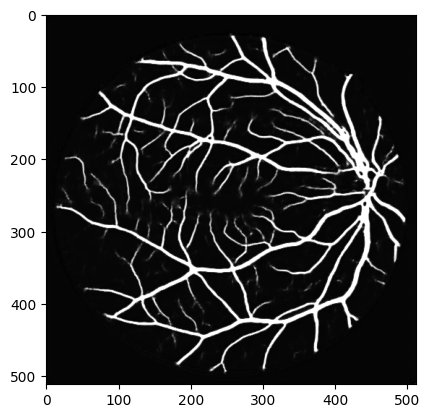

In [27]:
plt.imshow(pl[1][0], cmap='gray')

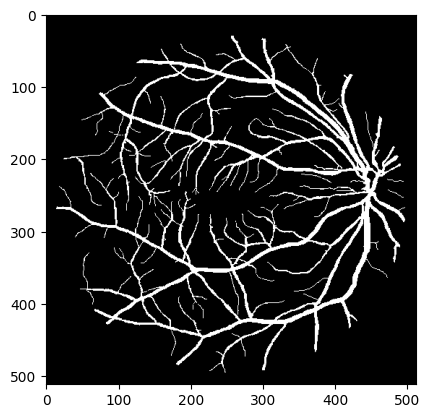

In [28]:
plt.imshow(label[0], cmap='gray')

In [29]:
pl[1][0]

array([[[0.39874268],
        [0.12278166],
        [0.06340359],
        ...,
        [0.10270295],
        [0.07971302],
        [0.4171636 ]],

       [[0.12215869],
        [0.04612778],
        [0.01928264],
        ...,
        [0.01289366],
        [0.00773459],
        [0.05298249]],

       [[0.02732607],
        [0.01829908],
        [0.02049938],
        ...,
        [0.02273545],
        [0.02630685],
        [0.1233425 ]],

       ...,

       [[0.03378286],
        [0.01641899],
        [0.01461337],
        ...,
        [0.01332108],
        [0.01066158],
        [0.02499987]],

       [[0.06649887],
        [0.01533239],
        [0.02774497],
        ...,
        [0.01377654],
        [0.01207345],
        [0.02672826]],

       [[0.32902312],
        [0.04549596],
        [0.05737432],
        ...,
        [0.03031607],
        [0.05624236],
        [0.18863049]]], dtype=float32)

In [30]:
label[0]

<tf.Tensor: shape=(512, 512, 1), dtype=float32, numpy=
array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]], dtype=float32)>

In [31]:
iou_metric(label[0], image[0][image[0] == 0]*pl[1][0])

ResourceExhaustedError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Mul]

In [42]:
im2 = image.numpy()
lb2 = label.numpy()
pl2 = pl[1]

In [47]:
mask = np.ones_like(im2)
mask[im2 == 0] = 0

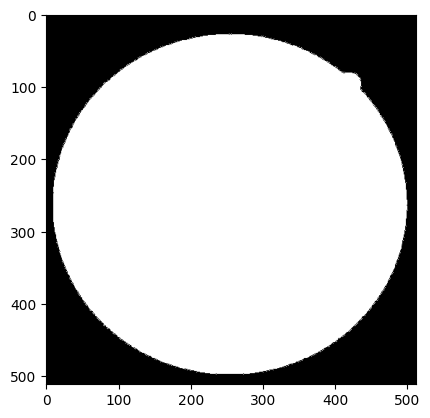

In [49]:
plt.imshow(mask[0], cmap='gray')

In [51]:
iou_metric(lb2[0], pl2[0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.5450822>